# SC-Elephant tutorial 

In [1]:
# not use GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import scelephant as el

%load_ext memory_profiler

2022-08-12 22:29:42.412882: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
el.bk.Wide( 100 )

In [4]:
%memit

peak memory: 718.14 MiB, increment: 0.09 MiB


In [5]:
el.bk.MPLSETTING_dpi_for_INLINE_plot( 150 )

**Convert MTX -> RamData**

In [6]:
# define working directory
path_folder = '/home/project/Single_Cell_Full_Length_Atlas/data/pipeline/20211116_ouroboros_short_read_public_data_mining/public_data/HCA/scarab_short_read_out/'

# create RamData from 10X-formateed MTX
el.create_ramdata_from_mtx( 
    f'{path_folder}all_features_only_gene_226842_barcodes_sorted/', 
    f'{path_folder}all_features_only_gene_226842_barcodes_sorted_ramdata/'
)

In [7]:
%memit

peak memory: 721.97 MiB, increment: 0.00 MiB


**loading RamData**

In [9]:
ram = el.RamData( f'{path_folder}all_features_only_gene_226842_barcodes_sorted_ramdata/' )

'raw' layer has been loaded


In [10]:
%memit

peak memory: 798.93 MiB, increment: 0.00 MiB


**view RamData**

In [12]:
ram

<RamData object (226842 barcodes X 54504 features, 218907267 records in the currently active layer 'raw') stored at /home/project/Single_Cell_Full_Length_Atlas/data/pipeline/20211116_ouroboros_short_read_public_data_mining/public_data/HCA/scarab_short_read_out/all_features_only_gene_226842_barcodes_sorted_ramdata/
	with the following layers : {'raw'}
		current layer is 'raw'>

**preprocessing**

100%|██████████████████████████████████████████████████████████████| 12363796368/12363796368 [01:23<00:00, 147504267.08it/s]


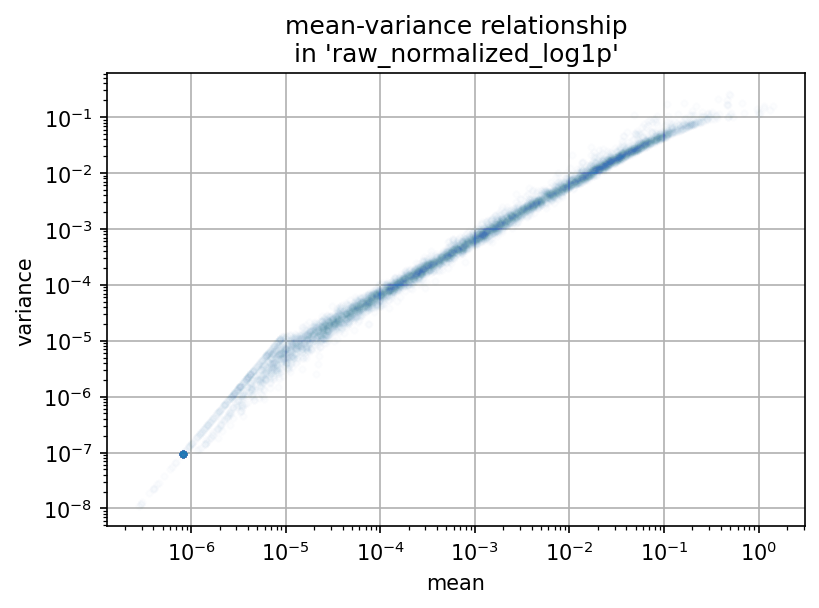

100%|████████████████████████████████████████████████████████████████| 7680485664/7680485664 [00:55<00:00, 138418838.59it/s]


apply operation raw > normalized_log1p_scaled has been completed


In [13]:
ram.prepare_dimension_reduction_from_raw( 
    name_layer_raw = 'raw', 
    name_layer_out = 'normalized_log1p_scaled', 
    min_counts = 500, 
    min_features = 100, 
    int_total_count_target = 10000, 
    int_num_highly_variable_features = 2000, 
    max_value = 10, 
    dict_kw_hv = { 
        'float_min_mean' : 0.01, 
        'float_min_variance' : 0.01, 
        'name_col_filter' : 'filter_normalized_log1p_highly_variable'
    }
)

**prepare dimension reduction**

In [14]:
int_num_barcodes_in_pumap_batch = 22000
int_num_barcodes_for_a_batch = 20000
float_prop_subsampling_pca = 0.3

**train PCA**

'normalized_log1p_scaled' layer has been loaded


 48%|██████████████████████████████████████                                          | 20000/41991 [00:39<00:43, 504.52it/s]

fit completed for 1-20000 barcodes


 95%|████████████████████████████████████████████████████████████████████████████▏   | 40000/41991 [01:21<00:04, 487.46it/s]

fit completed for 20001-40000 barcodes


100%|████████████████████████████████████████████████████████████████████████████████| 41991/41991 [02:06<00:00, 332.59it/s]


fit completed for 40001-41991 barcodes
fit completed
ipca.ipca model saved.


IncrementalPCA(batch_size=20000, copy=False, n_components=30)

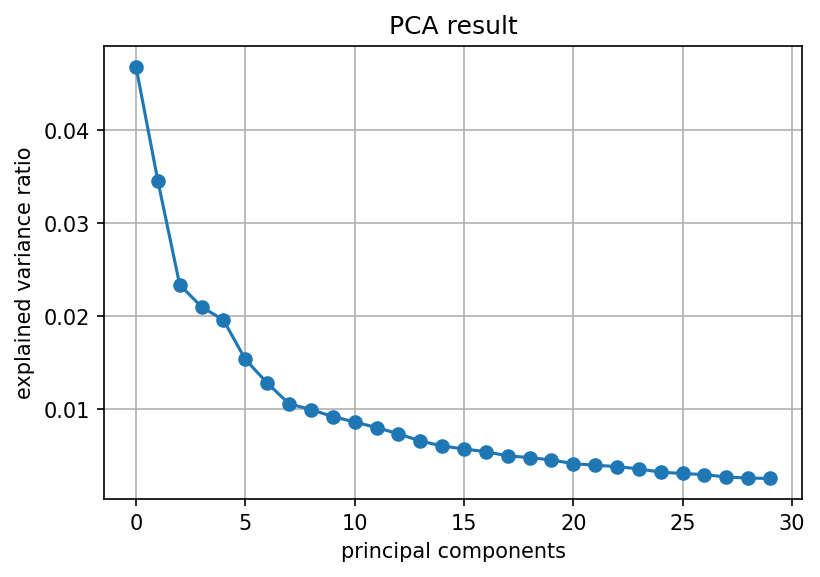

In [15]:
ram.train_pca( 
    name_layer = 'normalized_log1p_scaled', 
    int_num_components = 30, 
    int_num_barcodes_in_ipca_batch = int_num_barcodes_for_a_batch, 
    name_col_filter = 'filter_pca', 
    float_prop_subsampling = float_prop_subsampling_pca, 
    name_col_filter_subsampled = 'filter_pca_subsampled', 
    flag_ipca_whiten = False, 
    name_model = 'ipca', 
    int_num_threads = 3, 
    flag_show_graph = True
)

In [16]:
%memit

peak memory: 1098.30 MiB, increment: 0.04 MiB


**apply PCA**

In [17]:
ram.apply_pca( 
    name_model = 'ipca', 
    name_layer = 'normalized_log1p_scaled', 
    name_col = 'X_pca', 
    name_col_filter = 'filter_pca', 
    int_n_components_in_a_chunk = 20, 
    int_num_threads = 5
)

ramtx for querying features efficiently is not available for layer normalized_log1p_scaled, containing the following modes: {'sparse_for_querying_barcodes'}


100%|█████████████████████████████████████████████████████████████████████| 35095566.0/35095566 [00:39<00:00, 888165.34it/s]


In [18]:
%memit

peak memory: 1097.02 MiB, increment: 0.00 MiB


**perform subsampling**

In [19]:
ram

<RamData object (140916/226842 barcodes X 1999/54504 features, 35095566 records in the currently active layer 'normalized_log1p_scaled') stored at /home/project/Single_Cell_Full_Length_Atlas/data/pipeline/20211116_ouroboros_short_read_public_data_mining/public_data/HCA/scarab_short_read_out/all_features_only_gene_226842_barcodes_sorted_ramdata/
	with the following layers : {'normalized_log1p_scaled', 'raw'}
		current layer is 'normalized_log1p_scaled'>

In [20]:
ram.subsample( 
    int_num_entries_to_use = int_num_barcodes_for_a_batch, 
    int_num_entries_to_subsample = int_num_barcodes_in_pumap_batch, 
    int_num_iterations_for_subsampling = 2, 
    name_col_data = 'X_pca', 
    int_num_components_data = 20, 
    int_num_clus_expected = 20, 
    name_col_label = 'subsampling_label', 
    name_col_avg_dist = 'subsampling_avg_dist', 
    axis = 'barcodes', 
    name_col_filter = 'filter_pca', 
    name_col_filter_subsampled = "filter_subsampled", 
    resolution = 0.7, 
    directed = True, 
    use_weights = True, 
    dict_kw_leiden_partition = { 'n_iterations' : -1, 'seed' : 0 }, 
    n_neighbors = 20, 
    dict_kw_pynndescent = { 'low_memory' : True, 'n_jobs' : None, 'compressed' : False }, 
    int_num_threads = 10, 
    int_num_entries_in_a_batch = int_num_barcodes_for_a_batch
)

ramtx for querying features efficiently is not available for layer normalized_log1p_scaled, containing the following modes: {'sparse_for_querying_barcodes'}
[Info] [RamData.subsample] iteration #0 started.
[Info] [RamData.leiden] knn-graph loaded
subsampling_label None 0
[Info] [RamData.leiden] clustering completed for 19838 number of barcodes
leiden.knn_classifier model saved.
[Info] [RamData.train_label] training of labels completed for 19838 number of entries of the axis 'barcodes'
ramtx for querying features efficiently is not available for layer normalized_log1p_scaled, containing the following modes: {'sparse_for_querying_barcodes'}
[Info] [RamData.apply_label] the nearest-neighbor search started


100%|████████████████████████████████████████████████████████████████████████████| 140916/140916 [00:01<00:00, 99873.92it/s]


[Info] [RamData.subsample] iteration #0 calculating density information started
ramtx for querying features efficiently is not available for layer normalized_log1p_scaled, containing the following modes: {'sparse_for_querying_barcodes'}
ramtx for querying features efficiently is not available for layer normalized_log1p_scaled, containing the following modes: {'sparse_for_querying_barcodes'}


100%|███████████████████████████████████████████████████████████████████████████| 140916/140916 [00:01<00:00, 113322.84it/s]


[Info] [RamData.subsample] iteration #0 subsampling started


100%|████████████████████████████████████████████████████████████████████████████| 140916/140916 [00:01<00:00, 97100.39it/s]


ramtx for querying features efficiently is not available for layer normalized_log1p_scaled, containing the following modes: {'sparse_for_querying_barcodes'}
[Info] [RamData.subsample] iteration #1 started.
[Info] [RamData.leiden] knn-graph loaded
subsampling_label None 1
[Info] [RamData.leiden] clustering completed for 19987 number of barcodes
leiden.knn_classifier model deleted.
leiden.knn_classifier model saved.
[Info] [RamData.train_label] training of labels completed for 19987 number of entries of the axis 'barcodes'
ramtx for querying features efficiently is not available for layer normalized_log1p_scaled, containing the following modes: {'sparse_for_querying_barcodes'}
[Info] [RamData.apply_label] the nearest-neighbor search started


100%|████████████████████████████████████████████████████████████████████████████| 140916/140916 [00:01<00:00, 86259.80it/s]


[Info] [RamData.subsample] iteration #1 calculating density information started
ramtx for querying features efficiently is not available for layer normalized_log1p_scaled, containing the following modes: {'sparse_for_querying_barcodes'}
ramtx for querying features efficiently is not available for layer normalized_log1p_scaled, containing the following modes: {'sparse_for_querying_barcodes'}


100%|███████████████████████████████████████████████████████████████████████████| 140916/140916 [00:01<00:00, 115369.41it/s]


[Info] [RamData.subsample] iteration #1 subsampling started


100%|███████████████████████████████████████████████████████████████████████████| 140916/140916 [00:01<00:00, 124040.42it/s]


ramtx for querying features efficiently is not available for layer normalized_log1p_scaled, containing the following modes: {'sparse_for_querying_barcodes'}


In [21]:
%memit

peak memory: 1654.25 MiB, increment: 0.00 MiB


**1st UMAP training**

In [22]:
ram.bc.change_filter( 'filter_subsampled' )
ram.train_umap( 
    name_col_pca = 'X_pca', 
    int_num_components_pca = 20, 
    int_num_components_umap = 2, 
    name_col_filter = 'filter_subsampled', 
    name_pumap_model = 'pumap'
)

ramtx for querying features efficiently is not available for layer normalized_log1p_scaled, containing the following modes: {'sparse_for_querying_barcodes'}


2022-08-12 22:52:06.716846: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-12 22:52:06.717004: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: node211
2022-08-12 22:52:06.717024: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: node211
2022-08-12 22:52:06.717463: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.60.2
2022-08-12 22:52:06.717528: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.60.2
2022-08-12 22:52:06.717542: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.60.2
2022-08-12 22:52:06.746607: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in pe

Epoch 1/10
2801/2801 [==============================] - 35s 11ms/step - loss: 0.0888
Epoch 2/10
2801/2801 [==============================] - 32s 11ms/step - loss: 0.0708
Epoch 3/10
2801/2801 [==============================] - 33s 12ms/step - loss: 0.0658
Epoch 4/10
2801/2801 [==============================] - 33s 12ms/step - loss: 0.0625
Epoch 5/10
2801/2801 [==============================] - 33s 12ms/step - loss: 0.0605
Epoch 6/10
2801/2801 [==============================] - 33s 12ms/step - loss: 0.0595
Epoch 7/10
2801/2801 [==============================] - 32s 12ms/step - loss: 0.0581
Epoch 8/10
2801/2801 [==============================] - 32s 11ms/step - loss: 0.0572
Epoch 9/10
2801/2801 [==============================] - 39s 14ms/step - loss: 0.0566
Epoch 10/10
2801/2801 [==============================] - 34s 12ms/step - loss: 0.0559
[Info] [RamData.train_umap] training for 21989 entries completed
INFO:tensorflow:Assets written to: /home/project/Single_Cell_Full_Length_Atlas/data/

ParametricUMAP(batch_size=1000, dims=[20], encoder=<keras.engine.sequential.Sequential object at 0x1526429203a0>, optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x15258131f2e0>)

In [23]:
%memit

peak memory: 2743.45 MiB, increment: -1.08 MiB


**2nd UMAP training**

In [24]:
ram

<RamData object (21989/226842 barcodes X 1999/54504 features, 35095566 records in the currently active layer 'normalized_log1p_scaled') stored at /home/project/Single_Cell_Full_Length_Atlas/data/pipeline/20211116_ouroboros_short_read_public_data_mining/public_data/HCA/scarab_short_read_out/all_features_only_gene_226842_barcodes_sorted_ramdata/
	with the following layers : {'normalized_log1p_scaled', 'raw'}
		current layer is 'normalized_log1p_scaled'>

In [25]:
# 2nd training
ram.bc.change_filter( 'filtered_barcodes' )
ram.bc.filter = ram.bc.subsample( min( 1, int_num_barcodes_in_pumap_batch / ram.bc.filter.count( ) ) )
ram.bc.save_filter( 'filter_subsampled_randomly' )
ram.train_umap( 
    name_col_pca = 'X_pca', 
    int_num_components_pca = 20, 
    int_num_components_umap = 2, 
    name_col_filter = 'filter_subsampled_randomly', 
    name_pumap_model = 'pumap'
)

Pickle of ParametricUMAP model loaded from /home/project/Single_Cell_Full_Length_Atlas/data/pipeline/20211116_ouroboros_short_read_public_data_mining/public_data/HCA/scarab_short_read_out/all_features_only_gene_226842_barcodes_sorted_ramdata/models/pumap.pumap/model.pkl
Keras encoder model loaded from /home/project/Single_Cell_Full_Length_Atlas/data/pipeline/20211116_ouroboros_short_read_public_data_mining/public_data/HCA/scarab_short_read_out/all_features_only_gene_226842_barcodes_sorted_ramdata/models/pumap.pumap/encoder
Keras full model loaded from /home/project/Single_Cell_Full_Length_Atlas/data/pipeline/20211116_ouroboros_short_read_public_data_mining/public_data/HCA/scarab_short_read_out/all_features_only_gene_226842_barcodes_sorted_ramdata/models/pumap.pumap/parametric_model
Epoch 1/10
2791/2791 [==============================] - 32s 11ms/step - loss: 0.0781
Epoch 2/10
2791/2791 [==============================] - 33s 12ms/step - loss: 0.0732
Epoch 3/10
2791/2791 [===============

ParametricUMAP(batch_size=1000, dims=[20], encoder=<keras.engine.sequential.Sequential object at 0x15257a997130>, optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x1525813e22e0>, parametric_reconstruction_loss_fcn=<keras.losses.BinaryCrossentropy object at 0x1525806c7e80>)

In [26]:
%memit

peak memory: 2876.02 MiB, increment: 5.98 MiB


**Apply trained p-UMAP model**

In [27]:
# apply umap
ram.apply_umap( name_col_pca = 'X_pca', name_col_umap = 'X_umap', int_num_barcodes_in_pumap_batch = int_num_barcodes_for_a_batch, name_col_filter = 'filtered_barcodes', name_pumap_model = 'pumap' )

Pickle of ParametricUMAP model loaded from /home/project/Single_Cell_Full_Length_Atlas/data/pipeline/20211116_ouroboros_short_read_public_data_mining/public_data/HCA/scarab_short_read_out/all_features_only_gene_226842_barcodes_sorted_ramdata/models/pumap.pumap/model.pkl
Keras encoder model loaded from /home/project/Single_Cell_Full_Length_Atlas/data/pipeline/20211116_ouroboros_short_read_public_data_mining/public_data/HCA/scarab_short_read_out/all_features_only_gene_226842_barcodes_sorted_ramdata/models/pumap.pumap/encoder
Keras full model loaded from /home/project/Single_Cell_Full_Length_Atlas/data/pipeline/20211116_ouroboros_short_read_public_data_mining/public_data/HCA/scarab_short_read_out/all_features_only_gene_226842_barcodes_sorted_ramdata/models/pumap.pumap/parametric_model


100%|███████████████████████████████████████████████████████████████████████████| 140916/140916 [00:01<00:00, 101797.31it/s]


ParametricUMAP(batch_size=1000, dims=[20], encoder=<keras.engine.sequential.Sequential object at 0x152552be0eb0>, optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x152552be0d90>, parametric_reconstruction_loss_fcn=<keras.losses.BinaryCrossentropy object at 0x15258367ebe0>)

In [28]:
%memit

peak memory: 2886.50 MiB, increment: 0.00 MiB


**Convert RamData -> Scanpy AnnData for further detailed analysis**

In [32]:
# subsample features
ram.ft.filter = ram.ft.subsample( 0.01 )

ramtx for querying features efficiently is not available for layer normalized_log1p_scaled, containing the following modes: {'sparse_for_querying_barcodes'}


In [33]:
ram

<RamData object (140916/226842 barcodes X 14/54504 features, 35095566 records in the currently active layer 'normalized_log1p_scaled') stored at /home/project/Single_Cell_Full_Length_Atlas/data/pipeline/20211116_ouroboros_short_read_public_data_mining/public_data/HCA/scarab_short_read_out/all_features_only_gene_226842_barcodes_sorted_ramdata/
	with the following layers : {'normalized_log1p_scaled', 'raw'}
		current layer is 'normalized_log1p_scaled'>

In [34]:
adata = ram[ 'raw', :, [ 'str', 'raw_sum', 'filter_subsampled', 'filter_subsampled_randomly', 'filter_subsampled', { 'X_umap', 'subsampling_label' } ], :, [ 'str', 'raw_normalized_log1p_mean' ] ]
adata.obs[ 'name_sample' ] = list( e.split( '|', 1 )[ 0 ] for e in adata.obs.index.values )
adata.obs[ 'leiden_scelephant' ] = adata.obsm[ 'subsampling_label' ][ :, 1 ]
adata.obs[ 'leiden_scelephant' ] = adata.obs[ 'leiden_scelephant' ].astype( str ).astype( object )

'raw' layer has been loaded
[Axis barcodes] completed loading of 140916 number of strings
[Axis features] completed loading of 14 number of strings


In [35]:
%memit

peak memory: 2911.26 MiB, increment: 0.00 MiB


In [37]:
import scanpy as sc

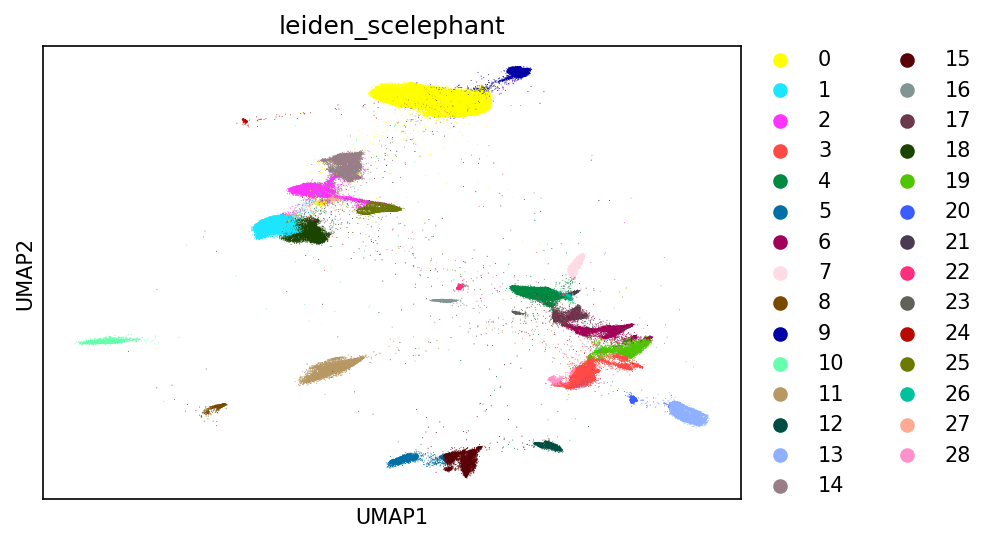

In [38]:
sc.pl.umap( adata, color = 'leiden_scelephant' )

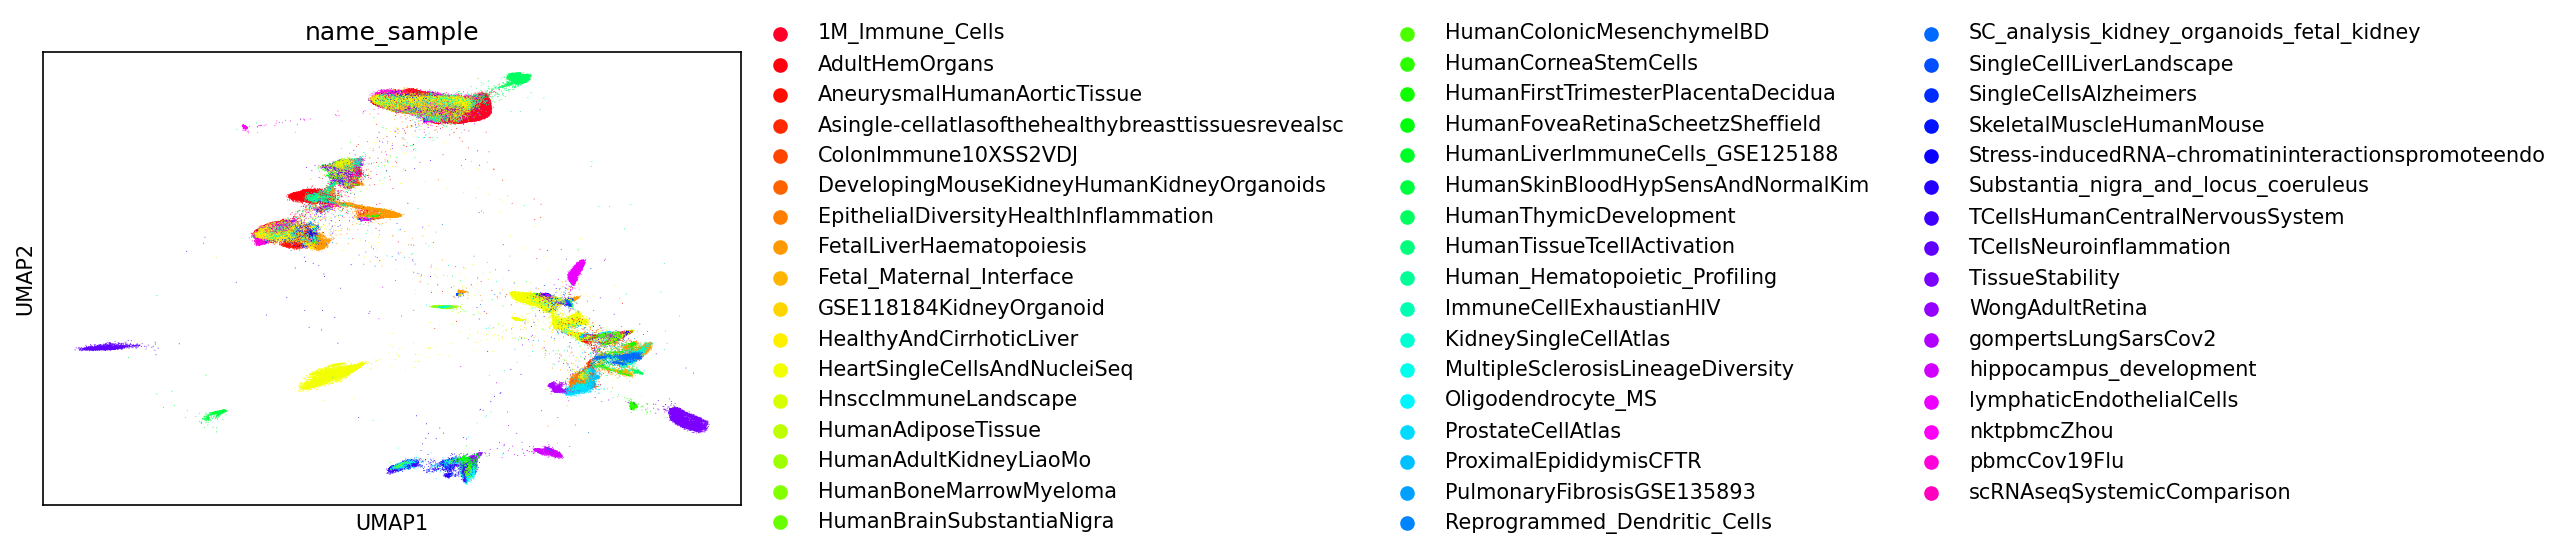

In [39]:
sc.pl.umap( adata, color = 'name_sample', palette = 'gist_rainbow' )

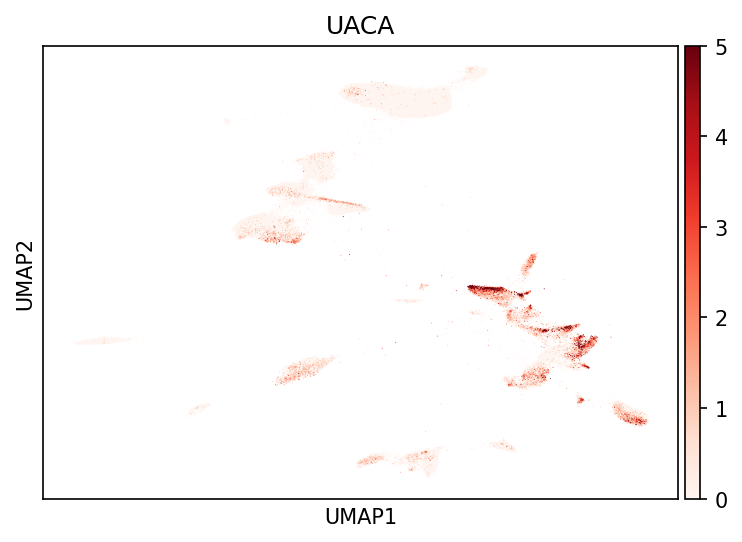

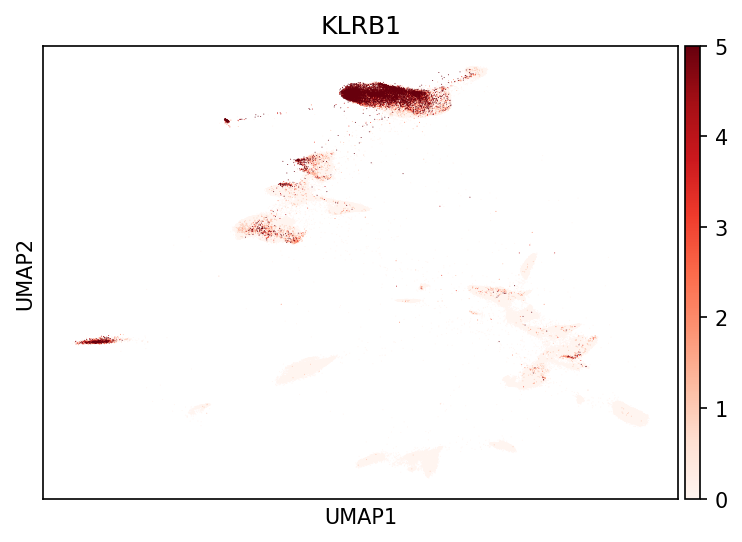

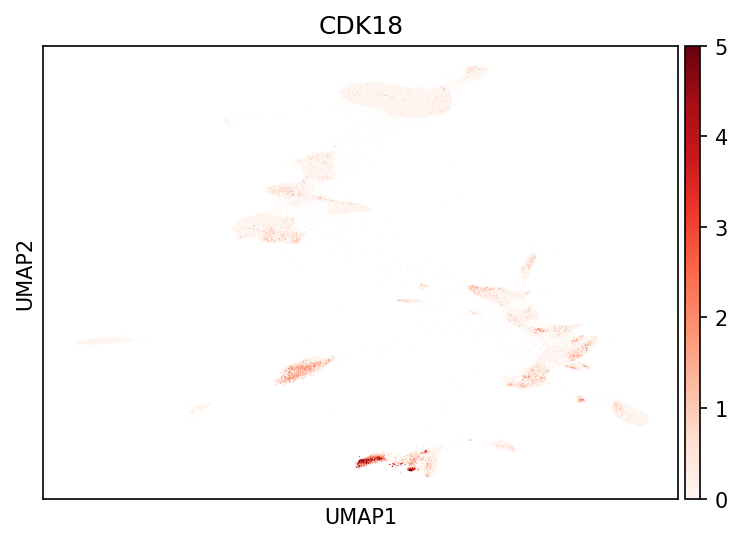

In [45]:
for e in adata.var.index.values[ : 3 ] :
    sc.pl.umap( adata, color = e, cmap = 'Reds', vmax = 5 )

# inside 'prepare_dimension_reduction_from_raw'

In [ ]:
self = ram
name_layer_raw = 'raw'
name_layer_out = 'normalized_log1p_scaled'
min_counts = 500
min_features = 100
int_total_count_target = 10000
int_num_highly_variable_features = 2000
max_value = 10
dict_kw_hv = { 'float_min_mean' : 0.01, 'float_min_variance' : 0.01, 'name_col_filter' : 'filter_normalized_log1p_highly_variable' } 

**cell filtering**

In [ ]:
self.summarize( name_layer_raw, 'barcode', 'sum' )

In [ ]:
%memit

In [ ]:
# filter cells
self.bc.filter = ( self.bc.all( ) if self.bc.filter is None else self.bc.filter ) & BA.to_bitarray( self.bc.meta[ f'{name_layer_raw}_sum', : ] > min_counts ) & BA.to_bitarray( self.bc.meta[ f'{name_layer_raw}_num_nonzero_values', : ] > min_features )
self.bc.save_filter( 'filtered_barcodes' ) # save filter for later analysis


In [ ]:
ram

In [ ]:
%memit

**surveying feature variance**

In [ ]:
# retrieve total raw count data for normalization
self.bc.meta.load_as_dict( f'{name_layer_raw}_sum' )
dict_count = self.bc.meta.dict[ f'{name_layer_raw}_sum' ] # retrieve total counts for each barcode as a dictionary

# retrieve the total number of barcodes
int_total_num_barcodes = self.bc.meta.n_rows

def func( self, int_entry_of_axis_for_querying, arr_int_entries_of_axis_not_for_querying, arr_value ) : # normalize count data of a single feature containing (possibly) multiple barcodes
    """ # 2022-07-06 23:58:38 
    """
    # perform normalization in-place
    for i, e in enumerate( arr_int_entries_of_axis_not_for_querying.astype( int ) ) : # iterate through barcodes
        arr_value[ i ] = arr_value[ i ] / dict_count[ e ] # perform normalization using the total count data for each barcode
    arr_value *= int_total_count_target

    # perform log1p transformation 
    arr_value = np.log10( arr_value + 1 )

    # calculate deviation
    int_num_records = len( arr_value ) # retrieve the number of records of the current entry
    dict_summary = { 'normalized_log1p_sum' : np.sum( arr_value ) if int_num_records > 30 else sum( arr_value ) } # if an input array has more than 30 elements, use np.sum to calculate the sum
    dict_summary[ 'normalized_log1p_mean' ] = dict_summary[ 'normalized_log1p_sum' ] / int_total_num_barcodes # calculate the mean
    arr_dev = ( arr_value - dict_summary[ 'normalized_log1p_mean' ] ) ** 2 # calculate the deviation
    dict_summary[ 'normalized_log1p_deviation' ] = np.sum( arr_dev ) if int_num_records > 30 else sum( arr_dev )
    dict_summary[ 'normalized_log1p_variance' ] = dict_summary[ 'normalized_log1p_deviation' ] / ( int_total_num_barcodes - 1 ) if int_total_num_barcodes > 1 else np.nan
    return dict_summary    

# calculate the metric for identifying highly variable genes
self.summarize( name_layer_raw, 'feature', func )


In [ ]:
%memit

In [ ]:
# identify highly variable genes
self.identify_highly_variable_features( name_layer = f'{name_layer_raw}_normalized_log1p', int_num_highly_variable_features = int_num_highly_variable_features, flag_show_graph = True, ** dict_kw_hv )

In [ ]:
%memit

**write normalized, scaled, log-transformed count data**

In [ ]:
# retrieve variance
self.ft.meta.load_as_dict( f'{name_layer_raw}_normalized_log1p_variance' )
dict_var = self.ft.meta.dict[ f'{name_layer_raw}_normalized_log1p_variance' ] # retrieve total counts for each barcode as a dictionary

# write log-normalized, scaled data for the selected highly variable features
def func( self, int_entry_of_axis_for_querying, arr_int_entries_of_axis_not_for_querying, arr_value ) : 
    """ # 2022-07-06 23:58:38 
    """
    # perform normalization 
    arr_value *= int_total_count_target / dict_count[ int_entry_of_axis_for_querying ] # perform normalization using the total count data for each barcode

    # perform log1p transformation 
    arr_value = np.log10( arr_value + 1 )

    # perform scaling in-place
    for i, e in enumerate( arr_int_entries_of_axis_not_for_querying.astype( int ) ) : # iterate through features
        arr_value[ i ] = arr_value[ i ] / dict_var[ e ] ** 0.5
    arr_value[ arr_value > max_value ] = max_value # capping values above 'max_value'

    # return results
    return int_entry_of_axis_for_querying, arr_int_entries_of_axis_not_for_querying, arr_value
self.apply( name_layer_raw, name_layer_out, func, [ [ 'dense', 'sparse_for_querying_barcodes' ] ] )

In [ ]:
%memit